In [1]:
# conda remove --name SCENIC --all
# conda create --name SCENIC python=3.6.3 
# conda activate SCENIC
# python -m pip install pandas
# git clone https://github.com/aertslab/pycisTopic.git
# cd pycisTopic
# python -m pip install .
# python -m pip install --upgrade pip setuptools
# python -m pip install scanpy
# python -m pip install  pyranges
# python -m pip install requests --ignore-installed certifi
# python -m pip install ray
# python -m pip install tmtoolkit
# python -m pip install gensim
# python -m pip install loomxpy
# python -m pip install pyrle
# python -m pip install polars
# python -m pip  install typing-extensions --upgrade
# python -m pip install pyarrow
# python -m pip install loompy
# python -m pip install pyscenic
# python -m pip install pickle5
# python -m pip install ipykernel
#  python -m pip install pyBigWig
# install jupyter-lab
# mv pycisTopic/ pycisTopic_repo
#git clone https://github.com/aertslab/scenicplus
#cd scenicplus
#pip install .



import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import scanpy
import os
import requests
import pyranges as pr
import pycisTopic
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
from pycisTopic.iterative_peak_calling import *
import anndata
import pickle
import pyarrow 
import re


def CountFrequency(my_list):
 
    # Creating an empty dictionary
    freq = {}
    for items in my_list:
        freq[items] = my_list.count(items)
 
    for key, value in freq.items():
        print("% s : % d" % (key, value))
 

outDir="SCENIC_results_MARCH2024/"
tmpDir="/tmp/"
#ray.shutdown()

In [2]:
infile = open(outDir + 'cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.03
Detected doublet rate = 96.5%
Estimated detectable doublet fraction = 99.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 97.3%
Elapsed time: 115.9 seconds
Detected doublet rate = 15.9%
Estimated detectable doublet fraction = 38.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 41.6%


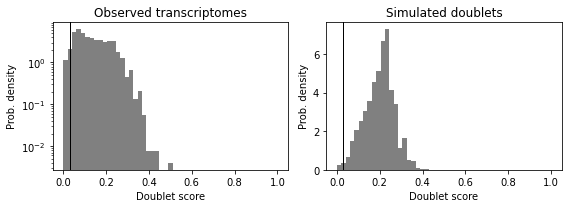

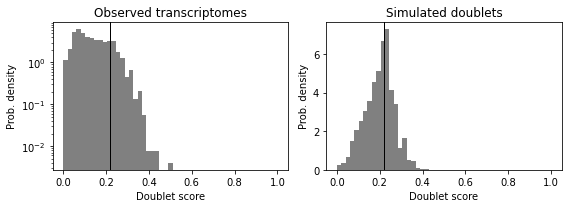

In [3]:
import scrublet as scr
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.plot_histogram();
scrub.call_doublets(threshold=0.22)
scrub.plot_histogram();
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, 
                        index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T


In [4]:
cistopic_obj.add_cell_data(scrublet, split_pattern = '-')
sum(cistopic_obj.cell_data.Predicted_doublets_fragments == True)
# Save with doublets
with open(outDir + 'cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [5]:
# Remove doublets
singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL = cistopic_obj.subset(singlets, copy=True, split_pattern='-')
print(cistopic_obj_noDBL)
with open(outDir + 'cisTopicObject_noDBL.pkl', 'wb') as f:
  pickle.dump(cistopic_obj_noDBL, f)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 10509 × 254124


In [6]:
# Remove cells without rna counterpart. ATAC cell equalent in scRNA
rna_cells = cistopic_obj_noDBL.cell_data.dropna().index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL_wRNA = cistopic_obj_noDBL.subset(rna_cells, copy=True, split_pattern='-')
print(cistopic_obj_noDBL_wRNA)

# Save without doublets
with open(outDir + 'cisTopicObject_noDBL_wRNA.pkl', 'wb') as f:
  pickle.dump(cistopic_obj_noDBL_wRNA, f)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 7774 × 254067


In [7]:
import pickle
infile = open(outDir + 'cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [8]:

# Topic: groups of peaks. Set of co-accessible regions 
from pycisTopic.cistopic_class import *
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,5,10,15,20,25],
                    n_cpu=6,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = tmpDir)

2024-04-04 01:08:17,589 root         INFO     Unable to poll TPU GCE metadata: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/attributes/accelerator-type (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f279cd48cd0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


2024-04-04 01:08:18,988	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(run_cgs_model pid=560076) 2024-04-04 01:08:24,746 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=560076) 2024-04-04 01:18:03,199 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=560073) 2024-04-04 01:08:24,745 cisTopic     INFO     Running model with 25 topics [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(run_cgs_model pid=560078) 2024-04-04 01:23:54,631 cisTopic     INFO     Model with 5 topics done!
(run_cgs_model pid=560074) 2024-04-04 01:35:05,374 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=560077) 2024-04-04 01:53:03,771 cisTopic     INFO     Model with 15 topics done!
(run_cgs_model pid=560075) 2024-04-04 02:15:25,175 cisTopic     INFO     Model with 20 topics done!
(run_cgs_model pid=560073) 2024-04-04 02:36:02,102 cisTopic     INFO     Mo

In [14]:
# Save
with open(outDir + 'models_500_iter_noDBL.pkl', 'wb') as f:
  pickle.dump(models, f)
  


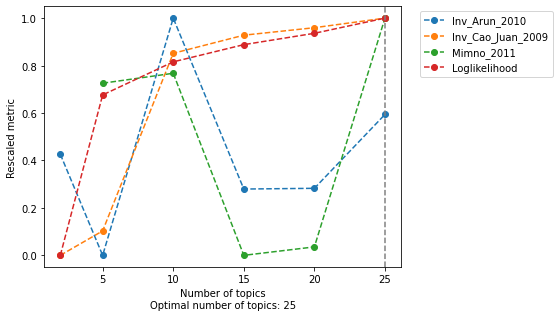

In [15]:
# Best model (?)

# Load functions
from pycisTopic.lda_models import *

import pickle
infile = open(outDir + 'models_500_iter_noDBL.pkl', 'rb')
models = pickle.load(infile)
infile.close()

model=evaluate_models(models,
                     select_model=25,
                     return_model=True,
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save= outDir + 'model_selection.pdf')


infile = open(outDir + 'cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Add model to cisTopicObject
cistopic_obj.add_LDA_model(model)

# Save
with open(outDir + 'cisTopicObject_noDBL.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [16]:
# Load cisTopic object
import pickle
infile = open(outDir + 'cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [17]:
from pycisTopic.clust_vis import *
find_clusters(cistopic_obj,
                 target  = 'cell',
                 k = 10,
                 res = [0.6, 0.8,1.2],
                 prefix = 'pycisTopic_',
                 scale = True,
                 split_pattern = '-')

2024-04-04 02:38:03,394 cisTopic     INFO     Finding neighbours
Columns ['pycisTopic_leiden_10_0.6'] will be overwritten
Columns ['pycisTopic_leiden_10_0.8'] will be overwritten
Columns ['pycisTopic_leiden_10_1.2'] will be overwritten


In [18]:
# Save
with open(outDir + 'cisTopicObject_noDBL.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [19]:
cistopic_obj.cell_data

,Dupl_nr_frag,wsnn_res.1.2,nCount_SCT,wsnn_res.0.4,cisTopic_log_nr_frag,wsnn_res.0.2,wsnn_res.1.1,wsnn_res.1.3,Predicted_doublets_fragments,Log_total_nr_frag,...,barcode,SCT.weight,wsnn_res.0.7,pycisTopic_leiden_10_0.6,clusters,seurat_clusters,wsnn_res.1.6,Doublet_scores_fragments,wsnn_res.2,pycisTopic_leiden_10_1.2
CCTATTTAGGGATTAG-1-6dpf___6dpf,21180,NaN,NaN,NaN,3.944927,NaN,NaN,NaN,False,4.762468,...,CCTATTTAGGGATTAG-1,NaN,NaN,2,NaN,NaN,NaN,0.171355,NaN,11
AGGAACCAGTAACCCG-1-6dpf___6dpf,3280,cluster_26,2451.0,cluster_1,3.41162,cluster_0,cluster_26,cluster_27,False,3.941362,...,AGGAACCAGTAACCCG-1,0.453839,cluster_20,4,cluster_cluster_0,cluster_5,cluster_29,0.171355,cluster_31,2
GCTGGTTCAGTTTACG-1-6dpf___6dpf,25519,cluster_30,2142.0,cluster_21,4.271633,cluster_15,cluster_30,cluster_31,False,4.792700,...,GCTGGTTCAGTTTACG-1,0.999983,cluster_24,3,cluster_cluster_6,cluster_8,cluster_32,0.193277,cluster_34,12
AGGTTAGAGGGCCATC-1-6dpf___6dpf,5595,cluster_26,1402.0,cluster_1,3.609381,cluster_0,cluster_26,cluster_27,False,4.193152,...,AGGTTAGAGGGCCATC-1,0.476799,cluster_20,5,cluster_cluster_0,cluster_5,cluster_29,0.219814,cluster_31,10
GGTTTAATCCCGCATT-1-6dpf___6dpf,6531,cluster_10,2372.0,cluster_6,3.649335,cluster_11,cluster_10,cluster_10,False,4.240998,...,GGTTTAATCCCGCATT-1,0.569405,cluster_7,5,cluster_cluster_8,cluster_24,cluster_10,0.219814,cluster_17,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGGTTTGTCCCGTTAC-1-2dpf___2dpf,2667,NaN,NaN,NaN,2.612784,NaN,NaN,NaN,False,3.573452,...,GGGTTTGTCCCGTTAC-1,NaN,NaN,0,NaN,NaN,NaN,0.042017,NaN,1
TGACCAAGTTGCACAA-1-2dpf___2dpf,2585,cluster_0,1807.0,cluster_0,2.592177,cluster_1,cluster_0,cluster_0,False,3.554973,...,TGACCAAGTTGCACAA-1,0.519119,cluster_0,0,cluster_cluster_1,cluster_0,cluster_0,0.094629,cluster_0,1
CAAACGCGTGCGCGTA-1-2dpf___2dpf,2132,cluster_12,1425.0,cluster_12,2.656098,cluster_9,cluster_12,cluster_12,False,3.524266,...,CAAACGCGTGCGCGTA-1,0.560067,cluster_12,0,cluster_cluster_4,cluster_2,cluster_12,0.090307,cluster_12,1
CTATAACCAAGCTTAT-1-2dpf___2dpf,3305,NaN,NaN,NaN,2.706718,NaN,NaN,NaN,False,3.673205,...,CTATAACCAAGCTTAT-1,NaN,NaN,0,NaN,NaN,NaN,0.064295,NaN,1
